# Quantum Generative Adversarial Networks: A PennyLane-Based Implementation with WGAN-GP

This project implements a Quantum Generative Adversarial Network (QGAN) using Variational Quantum Circuits (VQCs) with PennyLane and PyTorch. The generator is a quantum circuit that learns to produce samples from a 1D normal distribution, while the discriminator is a classical neural network. Training is stabilized with the WGAN-GP (Wasserstein GAN with Gradient Penalty) technique. The project demonstrates how hybrid quantum-classical models can be used for data generation tasks.



In [16]:
!pip install pennylane
!pip install "jax==0.4.28" "jaxlib==0.4.28"

In [17]:
from pennylane import numpy as np # PennyLane's numpy with autograde support
import torch
from torch import nn
import matplotlib.pyplot as plt
import pennylane as qml

## Checking library versions and selecting computation device

We first print the versions of PennyLane and PyTorch being used. Then, we set the computation device to GPU if it's available, otherwise fall back to CPU. This allows for faster training if GPU support is enabled in Colab.


In [18]:
# PyTorch ve PennyLane sürümlerini kontrol etme
print(f"PennyLane sürümü: {qml.__version__}")
print(f"PyTorch sürümü: {torch.__version__}")

PennyLane sürümü: 0.41.1
PyTorch sürümü: 2.6.0+cu124


In [19]:
# GPU varsa kullanalım (Colab'da Runtime -> Change runtime type -> GPU seçebilirsiniz)
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device_torch}")

Kullanılan cihaz: cpu


## Quantum device setup and project hyperparameters

We define the quantum device using `default.qubit` simulator with 2 qubits. We also specify key hyperparameters such as batch size, learning rate (reduced to stabilize training), latent vector dimension for the generator, and number of training epochs.


In [20]:
n_qubits = 2 # Numbers of qubit for generator
dev = qml.device("default.qubit", wires=n_qubits)

In [21]:
batch_size = 32
latent_dim = 2 # Üretecin girdi olarak alacağı gürültü vektörünün boyutu
# DÜZELTME 1: Öğrenme oranını düşürerek eğitimin daha kararlı olmasını sağlıyoruz.
lr = 0.0001 # 0.001'den düşürüldü
n_epochs = 8000 # Eğitim döngüsü sayısı

## Real data distribution

We define a simple real data distribution using a normal distribution with mean 0 and standard deviation 0.2. This serves as the target distribution for the quantum generator to learn and mimic.


In [22]:
def get_real_data(n_samples):
    return torch.tensor(np.random.normal(0, 0.2, size=(n_samples, 1)), dtype=torch.float32).to(device_torch)


##  Variational Quantum Circuit (Generator QNode)

This QNode defines a quantum generator circuit. It applies angle embedding followed by a layered entangling structure using rotation and CNOT gates. An extra layer has been added to improve circuit expressivity. The circuit outputs the expectation value of the PauliZ observable.


In [23]:
# Kuantum Üreteç Devresi (QNode)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_generator_circuit(noise):
    qml.AngleEmbedding(noise, wires=range(n_qubits))
    qml.RY(np.pi / 4, wires=0)
    qml.RX(np.pi / 2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(np.pi / 4, wires=1)
    qml.RX(np.pi / 2, wires=0)
    qml.CNOT(wires=[1, 0])

    return qml.expval(qml.PauliZ(0))

## Quantum Generator module

This PyTorch module wraps the QNode. It uses a linear layer to map latent noise vectors to quantum input angles. Since PennyLane does not natively support batch execution in QNodes with PyTorch, we loop over the batch manually and aggregate outputs.


In [24]:
# Kuantum Üreteç (PyTorch Modülü)
class QuantumGenerator(nn.Module):
    def __init__(self, latent_dim, n_qubits):
        super().__init__()
        self.linear = nn.Linear(latent_dim, n_qubits)

    def forward(self, z):
        # z: (batch_size, latent_dim)
        processed_z = self.linear(z) # (batch_size, n_qubits)


        results = []
        for p_z in processed_z:
            # Devreyi her bir gürültü vektörü için tek tek çalıştır
            result = quantum_generator_circuit(p_z)
            results.append(result)

        # Sonuçları tek bir tensörde birleştir
        q_out = torch.stack(results).unsqueeze(1)
        return q_out.float()

## Classical Discriminator module

A standard feedforward neural network is defined as the discriminator. It consists of two hidden layers with ReLU activation, and outputs a scalar representing the probability that the input is real or fake.


In [25]:
# Klasik Ayırt Edici (PyTorch Modülü)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

##  Gradient Penalty for WGAN-GP

We implement the gradient penalty term used in WGAN-GP to enforce the Lipschitz constraint. This helps stabilize GAN training by penalizing large gradients when interpolating between real and fake samples.


In [26]:
# WGAN-GP için Gradyan Cezası Fonksiyonu
def _gradient_penalty(discriminator, real_data, fake_data, device):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1).to(device)
    alpha = alpha.expand_as(real_data)

    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated.requires_grad_(True)

    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(prob_interpolated),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return ((gradients_norm - 1) ** 2).mean()

## Initializing models and optimizers

We create instances of the generator and discriminator models and move them to the selected device (CPU/GPU). We use Adam optimizers with β1 = 0.5 and β2 = 0.999, as commonly recommended for GANs.


In [27]:
# Modelleri ve optimizer'ları oluşturalım ve GPU'ya taşıyalım
generator = QuantumGenerator(latent_dim, n_qubits).to(device_torch)
discriminator = Discriminator().to(device_torch)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


##  Training the quantum GAN (WGAN-GP)

The training loop alternates between updating the discriminator and the generator.
- The discriminator is updated in every epoch using real and fake samples along with the gradient penalty.
- The generator is updated every 5 epochs by maximizing the discriminator’s prediction on fake data.

Training losses are printed at intervals, and we visualize the real vs generated data distributions every 1000 epochs.

## Distribution comparison (Real vs Generated)

We use histograms to compare real data with the quantum generator’s outputs every 1000 epochs. This helps track the learning progress and see how closely the generator mimics the target distribution.

##  Distribution comparison (Real vs Generated)

We use histograms to compare real data with the quantum generator’s outputs every 1000 epochs. This helps track the learning progress and see how closely the generator mimics the target distribution.



Eğitim başlıyor...
Epoch 0/8000 | D Loss: 8.8262 | G Loss: -0.0433


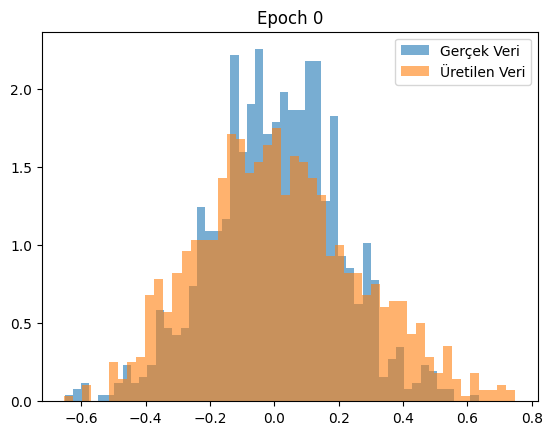

Epoch 1000/8000 | D Loss: 0.0398 | G Loss: -0.2431


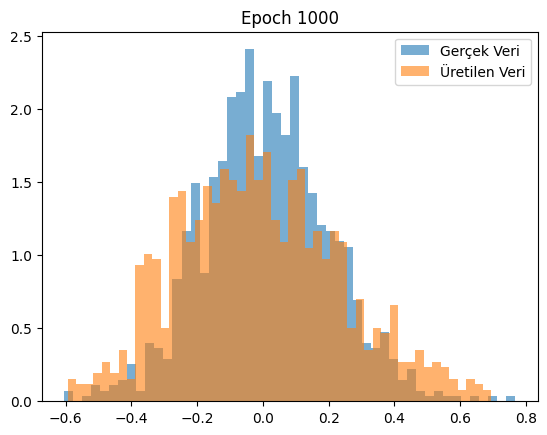

Epoch 2000/8000 | D Loss: -0.0003 | G Loss: -0.5334


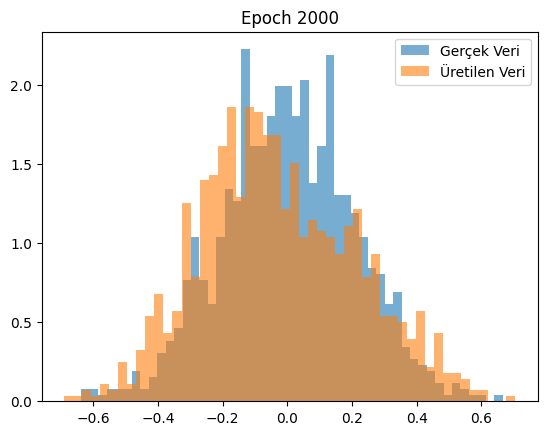

Epoch 3000/8000 | D Loss: 0.1001 | G Loss: -0.6467


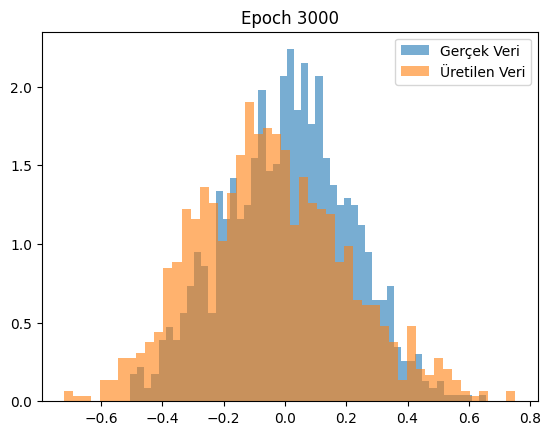

Epoch 4000/8000 | D Loss: 0.1059 | G Loss: -0.7488


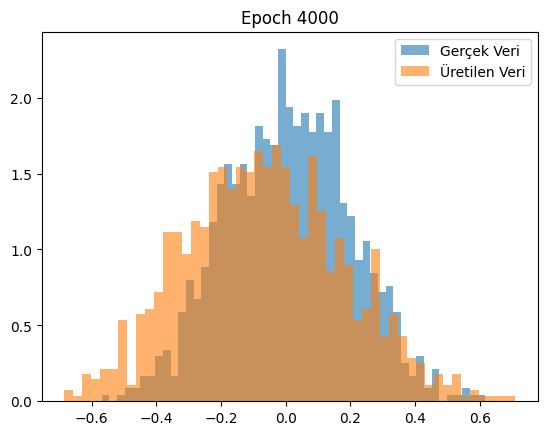

Epoch 5000/8000 | D Loss: 0.0984 | G Loss: -0.7702


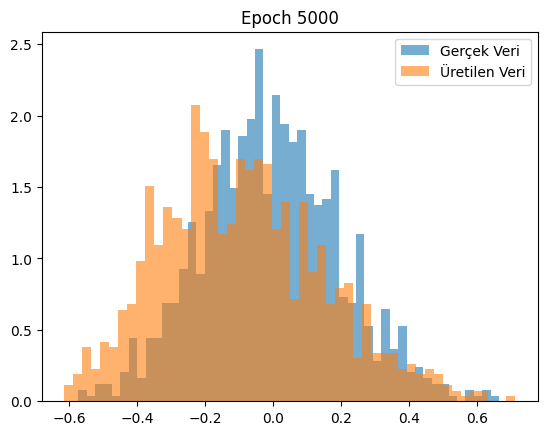

Epoch 6000/8000 | D Loss: -0.0520 | G Loss: -0.7807


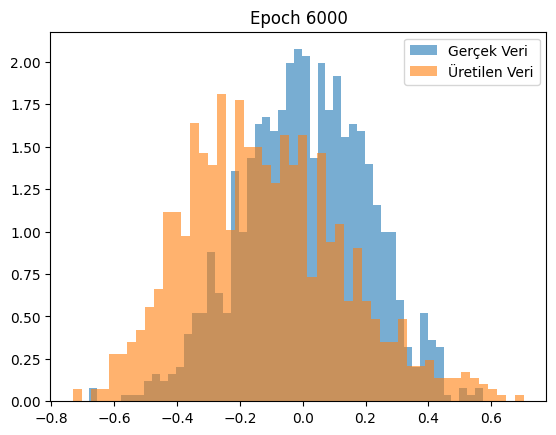

Epoch 7000/8000 | D Loss: 0.0905 | G Loss: -0.8374


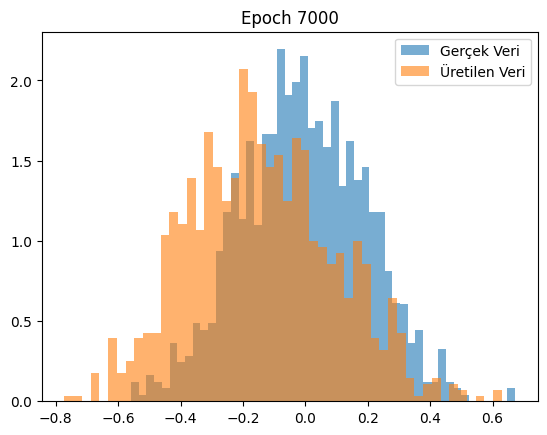

Epoch 8000/8000 | D Loss: 0.1202 | G Loss: -0.9165


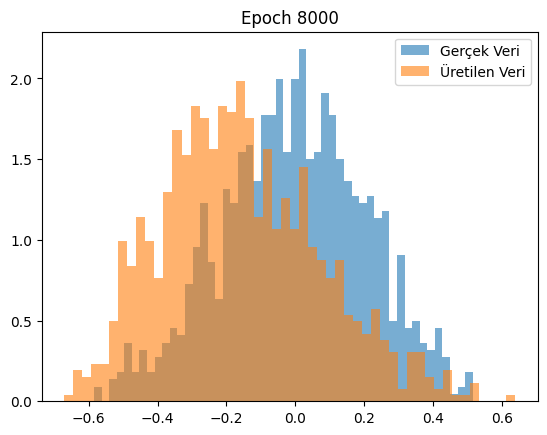


Eğitim tamamlandı!


In [28]:
# Eğitim döngüsü
print("\nEğitim başlıyor...")
for epoch in range(n_epochs + 1):
    # Ayırt Ediciyi Eğit
    optimizer_D.zero_grad()
    real_data = get_real_data(batch_size)
    noise = torch.randn(batch_size, latent_dim).to(device_torch)
    fake_data = generator(noise).detach()

    real_loss = discriminator(real_data).mean()
    fake_loss = discriminator(fake_data).mean()
    gp = _gradient_penalty(discriminator, real_data, fake_data, device_torch)
    d_loss = fake_loss - real_loss + 10 * gp
    d_loss.backward()
    optimizer_D.step()

    # Üreteci Eğit (Her 5 adımda bir)
    if epoch % 5 == 0:
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim).to(device_torch)
        fake_data = generator(noise)
        g_loss = -discriminator(fake_data).mean()
        g_loss.backward()
        optimizer_G.step()

    # Sonuçları belirli aralıklarla yazdır ve görselleştir
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{n_epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        real_data_example = get_real_data(1000).cpu() # Plotting için CPU'ya al
        with torch.no_grad():
            test_noise = torch.randn(1000, latent_dim).to(device_torch)
            generated_samples = generator(test_noise).cpu().numpy() # Plotting için CPU'ya al

            plt.hist(real_data_example.numpy(), bins=50, density=True, alpha=0.6, label='Gerçek Veri')
            plt.hist(generated_samples, bins=50, density=True, alpha=0.6, label='Üretilen Veri')
            plt.legend()
            plt.title(f"Epoch {epoch}")
            plt.show()

print("\nEğitim tamamlandı!")
